<a href="https://colab.research.google.com/github/iwatake2222/colaboratory_study/blob/master/sample/inference_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download an original model and test data

In [ ]:
''' Downlaod model '''
!wget https://github.com/onnx/models/raw/master/vision/classification/inception_and_googlenet/inception_v1/model/inception-v1-7.onnx -O model.onnx

In [ ]:
''' Download label '''
import numpy as np
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json -O label.json
import json
with open("label.json") as f:
  label_list = np.asarray(json.load(f))
# label_list = np.insert(label_list, 0, "background")

In [ ]:
''' Download test data '''
import os
import glob
import subprocess
def download(file_id, file_name):
  subprocess.run(["curl", "-sc", "/tmp/cookie", f"https://drive.google.com/uc?export=download&id={file_id}"])
  cmd = ["awk", "/_warning_/ {print $NF}", "/tmp/cookie"]
  code = subprocess.run(cmd, shell=False, stdout=subprocess.PIPE, check=True).stdout.decode("utf-8").replace("\n", "")
  subprocess.run(["curl", "-Lb", "/tmp/cookie", f"https://drive.google.com/uc?export=download&confirm={code}&id={file_id}", "-o", f"{file_name}"])
 
!wget https://coral.ai/static/docs/images/parrot.jpg

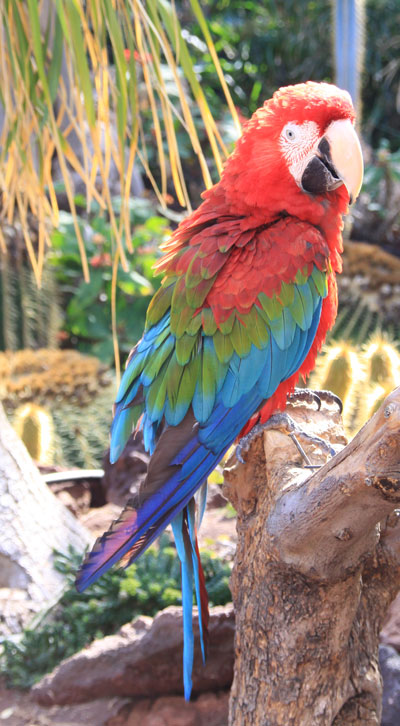

In [ ]:
''' Display test data '''
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img_original = cv2.imread("parrot.jpg")
cv2_imshow(img_original)

In [ ]:
''' Preprocess '''
def preprocess(img_original):
  shape = (224, 224) 
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  # mean = np.array([0.5, 0.5, 0.5])
  # std = np.array([0.5, 0.5, 0.5])
  # mean = np.array([0.0, 0.0, 0.0])
  # std = np.array([1.0, 1.0, 1.0])
  img = img_original.copy()
  img = cv2.resize(img, shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img = img / 255.
  # img = (img - mean) / std
  img = img.astype(np.float32)
  tensor = cv2.dnn.blobFromImage(img)
  # tensor = img.transpose(2, 0, 1).reshape(1, 3, 224, 224)
  return tensor

def preprocess_for_quant(img_original):
  shape = (224, 224) 
  img = img_original.copy()
  img = cv2.resize(img, shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.uint8)
  tensor = cv2.dnn.blobFromImage(img)
  return tensor

# Inference by ONNX

In [ ]:
''' Install onnx '''
!pip install onnx
!pip install onnxruntime
import onnx
import onnxruntime

In [ ]:
model = onnx.load("model.onnx")
try:
    onnx.checker.check_model(model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

The model is valid!


In [ ]:
''' Load model '''
sess = onnxruntime.InferenceSession("model.onnx")

''' Run inference '''
input = preprocess(img_original)
input_name = sess.get_inputs()[0].name
output = sess.run(None, {input_name: input})[0]

''' Show result '''
scores = np.array(output[0])
result = np.argmax(scores)
print("Result is {} ({}) [{:.2f}]".format(label_list[result], result, scores[result]))

Result is macaw (88) [1.00]


# Inference by OpenCV


In [32]:
import cv2

''' Load model '''
net = cv2.dnn.readNetFromONNX("model.onnx")

''' Run inference '''
input = preprocess(img_original)
net.setInput(input)
output = net.forward([None])[0]

''' Show result '''
scores = np.array(output[0])
result = np.argmax(scores)
print("Result is {} ({}) [{:.2f}]".format(label_list[result], result, scores[result]))

Result is macaw (88) [1.00]
